In [ ]:
import pandas as pd
from scipy.stats import levene, shapiro
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

data = pd.read_excel('/content/archheart_rate.xlsx')

data = data.dropna(subset=["T3", "T4"])

columns = ["T1", "T2", "T3", "T4"]
levene_results = []
for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if j > i:
            levene_test = levene(data[col1], data[col2])
            levene_results.append(((col1, col2), levene_test.statistic, levene_test.pvalue))

shapiro_results = []
for col in columns:
    shapiro_test = shapiro(data[col])
    shapiro_results.append((shapiro_test.statistic, shapiro_test.pvalue))

formula = "valor ~ grupo"
long_data = pd.melt(data, var_name='grupo', value_vars=columns, value_name='valor')
model = ols(formula, data=long_data).fit()
anova_table = anova_lm(model)

print("Teste de Levene:")
for result in levene_results:
    (col1, col2), statistic, pvalue = result
    print(f"Colunas {col1} e {col2}:")
    print("Estatística de teste:", statistic)
    print("Valor p:", pvalue)
    print()

print("Teste de Shapiro-Wilk:")
for i, col in enumerate(columns):
    print(f"Coluna {col}:")
    print("Estatística de teste:", shapiro_results[i][0])
    print("Valor p:", shapiro_results[i][1])
    print()

print("Tabela ANOVA:")
print(anova_table)

Teste de Levene:
Colunas T1 e T2:
Estatística de teste: 25.719714296600515
Valor p: 4.3589493000714685e-07

Colunas T1 e T3:
Estatística de teste: 138.95833193348153
Valor p: 6.154023934442789e-31

Colunas T1 e T4:
Estatística de teste: 128.53541846824396
Valor p: 8.12453659408405e-29

Colunas T2 e T3:
Estatística de teste: 208.6537212494096
Valor p: 8.323845676019624e-45

Colunas T2 e T4:
Estatística de teste: 198.82013512306625
Valor p: 7.009118354307755e-43

Colunas T3 e T4:
Estatística de teste: 0.002724157291917194
Valor p: 0.9583804002693371

Teste de Shapiro-Wilk:
Coluna T1:
Estatística de teste: 0.990785539150238
Valor p: 2.2666641598334536e-05

Coluna T2:
Estatística de teste: 0.9154111742973328
Valor p: 6.955894249103389e-22

Coluna T3:
Estatística de teste: 0.8935468196868896
Valor p: 2.5102735323338164e-24

Coluna T4:
Estatística de teste: 0.8576120138168335
Valor p: 1.2929983941431395e-27

Tabela ANOVA:
              df        sum_sq        mean_sq             F  PR(>F)
gr

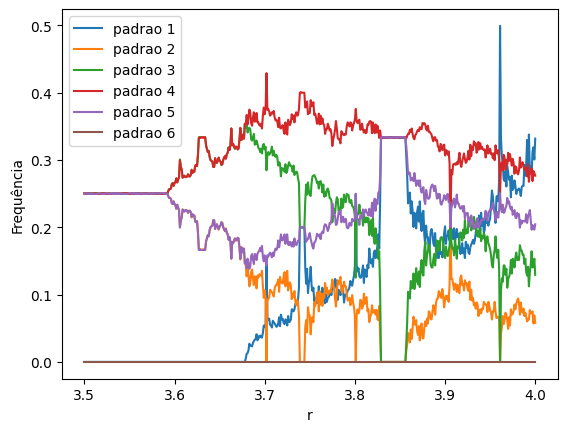

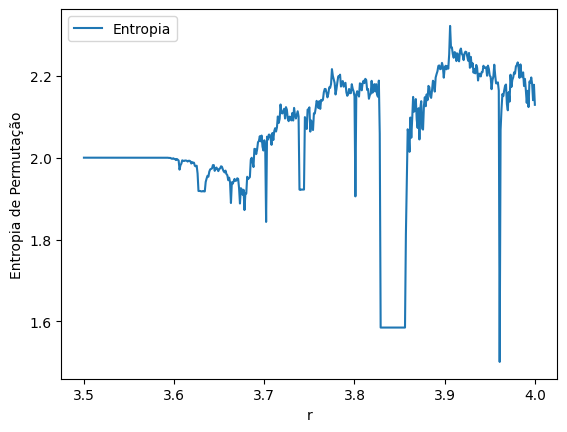

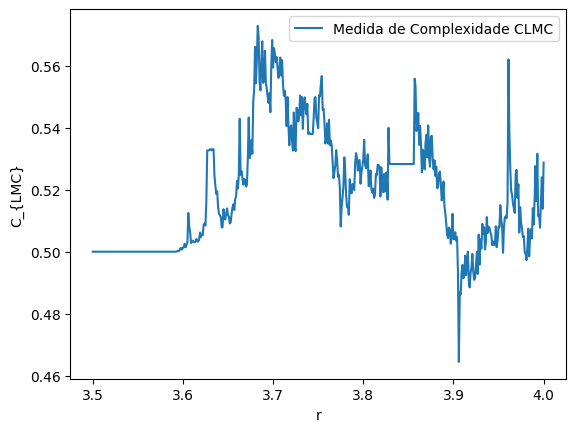

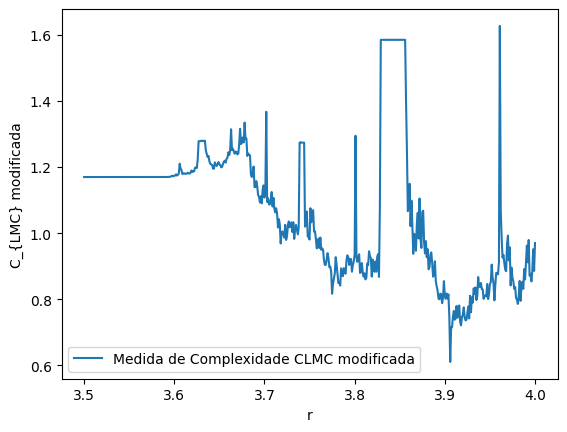

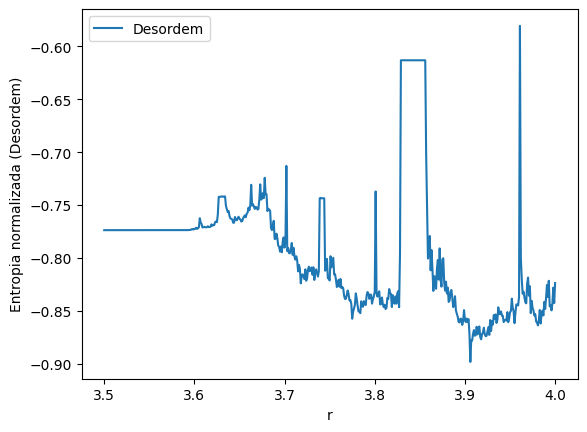

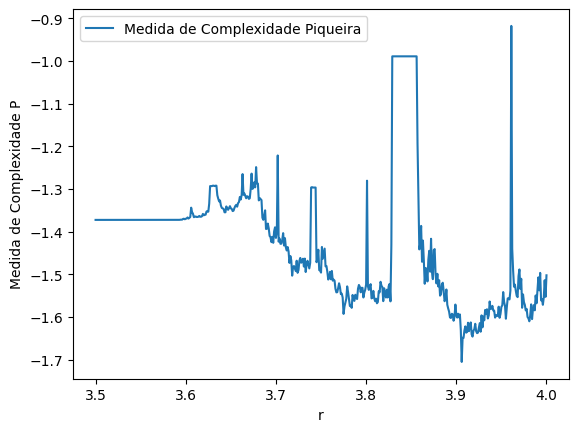

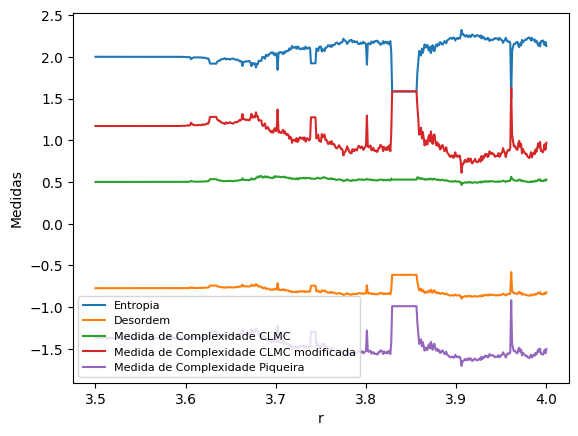

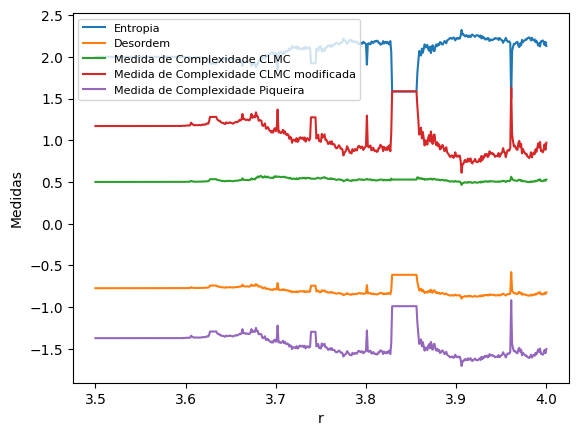

In [ ]:
from numpy.core.numeric import indices
import numpy as np
import matplotlib.pyplot as plt

def perm_indices(ts, wl, lag):
    m = len(ts)-(wl-1)*lag
    indcs = np.zeros(m, dtype=int)
    for i in range(1, wl):
        st = ts[(i-1)*lag: m + ((i-1)*lag)]
        for j in range(i, wl):
            indcs += st > ts[j*lag: m+j*lag]
        indcs *= wl-i
    return indcs + 1

Size = 1000 #tamanho da série
wl = 3 # tamanho dos padrões
num_states = np.math.factorial(wl) #quantidade de estados

fp_out = open('dados.dat','w') #gerando um arquivo de saida com nome dados.dat

# Gerando a base de dados
data = []
data_S = []
data_D02 = []
data_C02 = []
data_D01 = []
data_C01 = []
data_E = []
data_CE = []

for R in range(3500,4001):
    r = R*0.001

    x0 = np.random.rand() #condicao inicial aleatoria

    for t in range(1000): #descartando tempo transiente
        x = r*x0*(1-x0)
        x0 = x

    Serie = np.zeros(Size) #criando um array de zeros pra série

    for t in range(Size): #gerando os dados pra série
        x = r*x0*(1-x0)
        x0 = x
        Serie[t] = x0

    a1 = perm_indices(Serie, wl, 1) #sequenciando os padroes da série
    P = np.zeros(num_states) #criando um vetor de num_states espaços para armazenar as probabilidades
    for i in range(len(a1)): #pegando todos os pontos de a1
        P[a1[i]-1]+=1 #acresentando os valores das probabilidades

    P/=sum(P) #normalizando a probabilidade

    #definindo a função de entropia
    S = 0
    for i in range(num_states):
        if P[i] > 0.0:
             S -= P[i]*np.log2(P[i])

    #definindo a função "distânica_01"
    D01 = 0
    for i in range(num_states):
          D01 += (P[i]-1/wl)**2

    #definindo a função "distânica_02"
    D02 = 0
    for i in range(num_states):
        if P[i] > 0.0:
             D02 += P[i]*np.log2(P[i]/(1/num_states))

    #definindo uma função complexidade_01
    C01 = S*D01

    #definindo uma função complexidade_02
    C02 = S*D02

    ############## definindo medida de complexidade_03 (piqueira) ##################

    #Complexidade Estrutural

    E=S/(np.log2(1/num_states))

    k1=1
    k2=1
    # A definição da complecidade estrutural CE é:

    CE=(1-E)**k1*(E)**k2

    # salvando os valores de r e P no arquivo de saída
    fp_out.write('%lf ' % r)

    for i in range(num_states):
        fp_out.write('%lf ' % P[i])

    fp_out.write('\n')

    # adicionando os valores de P em data
    data.append(P)
    data_S.append(S)
    data_D01.append(D01)
    data_C01.append(C01)
    data_D02.append(D02)
    data_C01.append(C02)
    data_E.append(E)
    data_CE.append(CE)


fp_out.close() # fechando o arquivo de saída

#print(Serie):

# plotando o resultado
data = np.array(data)
data_S = np.array(data_S)
data_D01 = np.array(data_D01)
data_D02 = np.array(data_D02)
data_C02 = np.array(data_D02*data_S)
data_C01 = np.array(data_D01*data_S)
data_E = np.array(data_E)
data_CE = np.array(data_CE)
plt.plot(np.arange(3500, 4001)*0.001, data[:,0], label='padrao 1')
plt.plot(np.arange(3500, 4001)*0.001, data[:,1], label='padrao 2')
plt.plot(np.arange(3500, 4001)*0.001, data[:,2], label='padrao 3')
plt.plot(np.arange(3500, 4001)*0.001, data[:,3], label='padrao 4')
plt.plot(np.arange(3500, 4001)*0.001, data[:,4], label='padrao 5')
plt.plot(np.arange(3500, 4001)*0.001, data[:,5], label='padrao 6')
plt.legend()
plt.xlabel('r')
plt.ylabel('Frequência')
plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_S, label='Entropia')
plt.legend()
plt.xlabel('r')
plt.ylabel('Entropia de Permutação')
plt.show()
#plt.plot(np.arange(3500, 4000)*0.001, data_D01, label='Distancia 01')
#plt.legend()
#plt.xlabel('r')
#plt.ylabel('Desequilíbrio')
#plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_C01, label='Medida de Complexidade CLMC')
plt.legend()
plt.xlabel('r')
plt.ylabel('C_{LMC}')
plt.show()
#plt.plot(np.arange(3500, 4000)*0.001, data_D02, label='Distancia 02')
#plt.legend()
#plt.xlabel('r')
#plt.ylabel('Distancia da DU extensiva')
#plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_C02, label='Medida de Complexidade CLMC modificada')
plt.legend()
plt.xlabel('r')
plt.ylabel('C_{LMC} modificada')
plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_E, label='Desordem')
plt.legend()
plt.xlabel('r')
plt.ylabel('Entropia normalizada (Desordem)')
plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_CE, label='Medida de Complexidade Piqueira')
plt.legend()
plt.xlabel('r')
plt.ylabel('Medida de Complexidade P')
plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_S, label='Entropia')
plt.plot(np.arange(3500, 4001)*0.001, data_E, label='Desordem')
plt.plot(np.arange(3500, 4001)*0.001, data_C01, label='Medida de Complexidade CLMC')
plt.plot(np.arange(3500, 4001)*0.001, data_C02, label='Medida de Complexidade CLMC modificada')
plt.plot(np.arange(3500, 4001)*0.001, data_CE, label='Medida de Complexidade Piqueira')
plt.legend(fontsize=8,loc='lower left')
plt.xlabel('r')
plt.ylabel('Medidas')
plt.show()
plt.plot(np.arange(3500, 4001)*0.001, data_S, label='Entropia')
plt.plot(np.arange(3500, 4001)*0.001, data_E, label='Desordem')
plt.plot(np.arange(3500, 4001)*0.001, data_C01, label='Medida de Complexidade CLMC')
plt.plot(np.arange(3500, 4001)*0.001, data_C02, label='Medida de Complexidade CLMC modificada')
plt.plot(np.arange(3500, 4001)*0.001, data_CE, label='Medida de Complexidade Piqueira')
plt.legend(fontsize=8,loc='upper left')
plt.xlabel('r')
plt.ylabel('Medidas')
plt.show()